In [1]:
# 这个为能展示图片的
# 但最后只能达到80%的准确率
# 先导入torch
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm

# 然后晒一下自己的显卡，美滋滋^ ^
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(0))

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3080', major=8, minor=6, total_memory=10239MB, multi_processor_count=68)


In [2]:
def load_data(batch_size):
    # 常规的CV操作一下数据
    # 加入数据增广
    # trans = transforms.ToTensor()
    train_augs = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(p=0.8),
                                                 torchvision.transforms.ToTensor()])
    test_augs = test_augs = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    
    data_train = torchvision.datasets.CIFAR10(root="./data", train=True, transform=train_augs, download=False)
    data_test = torchvision.datasets.CIFAR10(root="./data", train=False, transform=test_augs, download=False)
    # 继续调用torch的库函数，自己写真的麻烦死，这个工作数得根据自己硬件的情况改
    # 然后这里返回的是迭代器，比自己写的循环好多了，虽然也就是个yield的事
    return (data.DataLoader(data_train, batch_size, shuffle=True,num_workers=4),
            data.DataLoader(data_test, batch_size, shuffle=False,num_workers=4))

下面图像的标签为：automobile


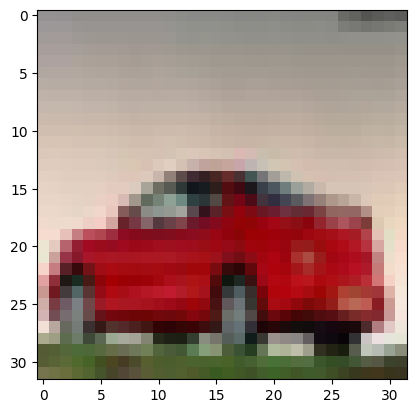

下面图像的标签为：truck


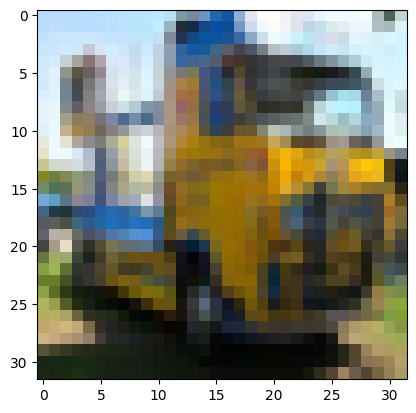

下面图像的标签为：cat


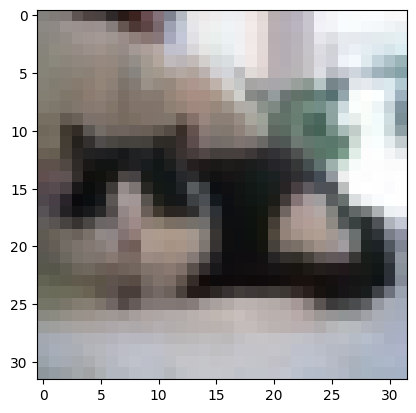

下面图像的标签为：deer


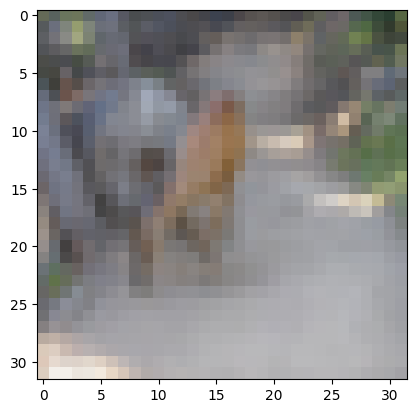

In [3]:
# 解码label
def decode(label):
    dic = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    print(dic[label])

show_size = 4
show_data, _ = load_data(show_size)
images, labels = next(iter(show_data))

for img, label in zip(images, labels):
    print("下面图像的标签为：", end='')
    decode(label)
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()

In [4]:
# 如果块的前后channel发生改变
# 就需要用一个单位卷积核来改变输入的channel用来相加
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, change=False, strides=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if change:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight) 
#     elif type(m) == nn.BatchNorm2d:
#         nn.init.constant_(m.weight, 1)
#         nn.init.constant_(m.bias, 0)        

In [5]:
block1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), 
                   nn.BatchNorm2d(64), nn.ReLU(), 
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                    )

block2 = nn.Sequential(Residual(64, 64), Residual(64, 64))

block3 = nn.Sequential(Residual(64, 128, change=True, strides=2), 
                   Residual(128, 128))

block4 = nn.Sequential(Residual(128, 256, change=True, strides=2), 
                   Residual(256, 256))

block5 = nn.Sequential(Residual(256, 512, change=True, strides=2), 
                   Residual(512, 512))

net = nn.Sequential(block1, block2, block3, block4, block5, 
                    nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(512, 10))

net.apply(init_weights)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-

In [6]:
# 直接把LeNet的搬过来
def test(net, test_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    # 同样要阻挡梯度的传播
    with torch.no_grad():
        for X, y in test_iter:
            X = X.to(device)
            y = y.to(device)
            # 后者为数组中元素的个数
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train(net, train_iter, test_iter, num_epochs, lr, device):
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    # 这个交叉熵不是简单的交叉熵，而是经过softmax之后的交叉熵
    loss = nn.CrossEntropyLoss()
    # 绘图库
    # animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc'])
    # 开始训练
    num_batches = len(train_iter)
    for i in range(10):
        with tqdm(total=int(num_epochs/10), desc='Iteration %d' % i) as pbar:
            for epoch in range(int(num_epochs/10)):
                # 用于计数的
                # metric = d2l.Accumulator(3)
                # 计算梯度以及dropout（这里没有用到）
                net.train()
                for i, (X, y) in enumerate(train_iter):
                    optimizer.zero_grad()
                    X, y = X.to(device), y.to(device)
                    y_hat = net(X)
                    l = loss(y_hat, y)
                    l.backward()
                    optimizer.step()
                    # 存数据，阻断梯度传播，相当于用detach
                    # with torch.no_grad():
                        # 分别是训练损失，训练的准确率，样本数
                        # metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
                    # train_l = metric[0] / metric[2]
                    # train_acc = metric[1] / metric[2]
                    # 定期画图
                    # if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                    #     animator.add(epoch + (i + 1) / num_batches,(train_l, train_acc, None))
                # 计算这个epoch下，测试集上的准确率
                test_acc = test(net, test_iter)
                if (epoch + 1) % 5 == 0:
                    pbar.set_postfix({
                        'test_acc':
                        '%.3f' % test_acc
                    })
                pbar.update(1)
            # animator.add(epoch + 1, (None, None, test_acc))
        # print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')

In [7]:
lr, num_epochs, batch_size = 0.01, 50, 256
train_iter, test_iter = load_data(batch_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(net, train_iter, test_iter, num_epochs, lr, device)
# 原始论文中Resnet20是8.75%错误率
# 不主动初始化，只用SGD是75%
# 改用Adam，用xavier初始化，也就80%左右
# 我又去看了原始论文，得用图像增广
# 缓解了过拟合，但得更长时间的训练

Iteration 9: 100%|███████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.69s/it, test_acc=0.769]
